In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta as ta
from datetime import datetime
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import torch
import torch.nn as nn
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.tuner import Tuner


from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler


mm = MinMaxScaler()
ss = StandardScaler()

#https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html#
#https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
#https://www.kaggle.com/code/iamleonie/time-series-forecasting-building-intuition/notebook?scriptVersionId=52169438

In [2]:
#ticker = "^TNX"
start=pd.to_datetime('2000-01-01', format='%Y-%m-%d')
today_date = datetime.today().strftime('%Y-%m-%d')


#EURUSD = "EURUSD=X"
#USDJPY = "USDJPY=X"

#13 WEEK TREASURY BILL ="^IRX"
#Treasury Yield 5 Years ="^FVX"
#CBOE Interest Rate 10 Year= "^TNX"
#Treasury Yield 30 Years ="^TYX"

#S&P 500 = "^GSPC"
#Nikkei 225= "^N225"

#Crude Oil="CL=F"


In [3]:
# download daily stock price data by passing in specified ticker and date range

#df = yf.download(ticker,start,end=today_date)

In [4]:
#fig = go.Figure(data=go.Scatter(x=df.index,y=df['Close'],mode='lines'))
#fig.show()

In [5]:
#Download data for indicators available on Yahoo Finance

yahoo_indicators = ['USDJPY=X','^GSPC','^N225'] 
tickers = yf.Tickers(yahoo_indicators)
df = tickers.history(start=start,end=today_date,interval='1D',)
df

#https://www.qmr.ai/yfinance-library-the-definitive-guide/#Fetch_Historical_Prices_using_yfinance

[*********************100%%**********************]  3 of 3 completed


Price            Close                            Dividends              \
Ticker        USDJPY=X        ^GSPC         ^N225  USDJPY=X ^GSPC ^N225   
Date                                                                      
2000-01-03  101.690002  1455.219971           NaN       0.0   0.0   NaN   
2000-01-04  103.139999  1399.420044  19002.859375       0.0   0.0   0.0   
2000-01-05  104.089996  1402.109985  18542.550781       0.0   0.0   0.0   
2000-01-06  105.230003  1403.449951  18168.269531       0.0   0.0   0.0   
2000-01-07  105.330002  1441.469971  18193.410156       0.0   0.0   0.0   
...                ...          ...           ...       ...   ...   ...   
2024-05-24  156.973007  5304.720215  38646.109375       0.0   0.0   0.0   
2024-05-27  156.869995          NaN  38900.019531       0.0   NaN   0.0   
2024-05-28  156.845001  5306.040039  38855.371094       0.0   0.0   0.0   
2024-05-29  157.261993  5266.950195  38556.871094       0.0   0.0   0.0   
2024-05-30  157.608002  5235.479980  38054.128906       0.0   0.0   0.0   

Price             High                                    Low  ...  \
Ticker        USDJPY=X        ^GSPC         ^N225    USDJPY=X  ...   
Date                                                           ...   
2000-01-03  103.330002  1478.000000           NaN  101.309998  ...   
2000-01-04  103.320000  1455.219971  19187.609375  101.470001  ...   
2000-01-05  104.480003  1413.270020  19003.509766  102.750000  ...   
2000-01-06  105.559998  1411.900024  18582.740234  103.900002  ...   
2000-01-07  105.879997  1441.469971  18285.730469  104.830002  ...   
...                ...          ...           ...         ...  ...   
2024-05-24  157.136993  5311.649902  38740.820312  156.867996  ...   
2024-05-27  156.955002          NaN  38900.019531  156.677994  ...   
2024-05-28  156.988998  5315.910156  38981.968750  156.612000  ...   
2024-05-29  157.639008  5282.270020  39141.988281  157.022003  ...   
2024-05-30  157.626999  5260.209961  38138.031250  156.427002  ...   

Price                           Open                            Stock Splits  \
Ticker             ^N225    USDJPY=X        ^GSPC         ^N225     USDJPY=X   
Date                                                                           
2000-01-03           NaN  102.070000  1469.250000           NaN          0.0   
2000-01-04  18937.449219  101.639999  1455.219971  18937.449219          0.0   
2000-01-05  18221.820312  103.129997  1399.420044  19003.509766          0.0   
2000-01-06  18168.269531  104.089996  1402.109985  18574.009766          0.0   
2000-01-07  18068.099609  105.260002  1403.449951  18194.050781          0.0   
...                  ...         ...          ...           ...          ...   
2024-05-24  38367.699219  156.973007  5281.450195  38506.031250          0.0   
2024-05-27  38667.929688  156.869995          NaN  38766.210938          0.0   
2024-05-28  38756.128906  156.845001  5315.910156  38879.148438          0.0   
2024-05-29  38524.238281  157.261993  5278.729980  38880.500000          0.0   
2024-05-30  37617.000000  157.608002  5259.770020  38112.769531          0.0   

Price                    Volume                             
Ticker     ^GSPC ^N225 USDJPY=X         ^GSPC        ^N225  
Date                                                        
2000-01-03   0.0   NaN      0.0  9.318000e+08          NaN  
2000-01-04   0.0   0.0      0.0  1.009000e+09          0.0  
2000-01-05   0.0   0.0      0.0  1.085500e+09          0.0  
2000-01-06   0.0   0.0      0.0  1.092300e+09          0.0  
2000-01-07   0.0   0.0      0.0  1.225200e+09          0.0  
...          ...   ...      ...           ...          ...  
2024-05-24   0.0   0.0      0.0  3.005510e+09   96300000.0  
2024-05-27   NaN   0.0      0.0           NaN   94200000.0  
2024-05-28   0.0   0.0      0.0  3.751540e+09  101200000.0  
2024-05-29   0.0   0.0      0.0  3.552750e+09  123900000.0  
2024-05-30   0.0   0.0      0.0  3.818750e+09  1173000

In [6]:
df.drop(columns=['Dividends', 'Open','High','Low','Stock Splits','Volume'],inplace=True)

In [7]:
df= df.droplevel(0, axis=1)

In [8]:
df.rename(columns={"USDJPY=X": "USDJPY", "^GSPC": "S&P", "^IRX": "US3M", "^N225": "Nikkei225"},inplace=True)
df

Ticker,USDJPY,S&P,Nikkei225
Date,,,
2000-01-03,101.690002,1455.219971,NaN
2000-01-04,103.139999,1399.420044,19002.859375
2000-01-05,104.089996,1402.109985,18542.550781
2000-01-06,105.230003,1403.449951,18168.269531
2000-01-07,105.330002,1441.469971,18193.410156
...,...,...,...
2024-05-24,156.973007,5304.720215,38646.109375
2024-05-27,156.869995,NaN,38900.019531
2024-05-28,156.845001,5306.040039,38855.371094


In [9]:
df = df.rename_axis('Date').reset_index()

In [10]:
df['Date'] = pd.to_datetime(df['Date'])

In [11]:
#df

In [12]:
'''
US core CPI (monthly)
https://fred.stlouisfed.org/series/CORESTICKM157SFRBATL

US core CPI (yearly)
https://fred.stlouisfed.org/series/CORESTICKM159SFRBATL

US core-core CPI (monthly)
https://fred.stlouisfed.org/series/CRESTKCPIXSLTRM157SFRBATL

US core-core CPI (yearly)
https://fred.stlouisfed.org/series/CRESTKCPIXSLTRM159SFRBATL

Japan National Consumer Price Index (CPI) YoY
https://www.investing.com/economic-calendar/national-cpi-992
    
'''




'\nUS core CPI (monthly)\nhttps://fred.stlouisfed.org/series/CORESTICKM157SFRBATL\n\nUS core CPI (yearly)\nhttps://fred.stlouisfed.org/series/CORESTICKM159SFRBATL\n\nUS core-core CPI (monthly)\nhttps://fred.stlouisfed.org/series/CRESTKCPIXSLTRM157SFRBATL\n\nUS core-core CPI (yearly)\nhttps://fred.stlouisfed.org/series/CRESTKCPIXSLTRM159SFRBATL\n\nJapan National Consumer Price Index (CPI) YoY\nhttps://www.investing.com/economic-calendar/national-cpi-992\n    \n'

In [13]:
#https://www.investing.com/rates-bonds/u.s.-2-year-bond-yield-historical-data

# Replace 'path/to/your/file.xlsx' with the actual path to your Excel file
US2y_file_path = '/Users/benny/Downloads/United States 2-Year Bond Yield Historical Data.csv'

# Use pandas to read the Excel file
US2y_df = pd.read_csv(US2y_file_path)

# Print the dataframe to verify it was read correctly
print(US2y_df)

            Date  Price   Open   High    Low Change %
0     05/31/2024  4.919  4.923  4.923  4.919   -0.17%
1     05/30/2024  4.927  4.981  4.985  4.921   -0.96%
2     05/29/2024  4.975  4.958  5.002  4.948   -0.08%
3     05/28/2024  4.978  4.935  4.981  4.903    0.88%
4     05/27/2024  4.935  4.938  4.938  4.935   -0.26%
...          ...    ...    ...    ...    ...      ...
4807  01/09/2006  4.353  4.353  4.353  4.353   -0.30%
4808  01/06/2006  4.366  4.366  4.366  4.366    0.95%
4809  01/05/2006  4.325  4.325  4.325  4.325    0.49%
4810  01/04/2006  4.304  4.304  4.304  4.304   -0.67%
4811  01/03/2006  4.333  4.333  4.333  4.333   -1.61%

[4812 rows x 6 columns]


In [14]:
US2y_df['Date'] = pd.to_datetime(US2y_df['Date'], format='mixed')
#US2y_df.set_index('Date',inplace=True)
#US2y_df.sort_index(ascending=True,inplace=True)
US2y_df.drop(['Open','High','Low','Change %'], axis=1, inplace=True)
US2y_df.rename(columns={"Price": "US2y_df"},inplace=True)
print(US2y_df)

           Date  US2y_df
0    2024-05-31    4.919
1    2024-05-30    4.927
2    2024-05-29    4.975
3    2024-05-28    4.978
4    2024-05-27    4.935
...         ...      ...
4807 2006-01-09    4.353
4808 2006-01-06    4.366
4809 2006-01-05    4.325
4810 2006-01-04    4.304
4811 2006-01-03    4.333

[4812 rows x 2 columns]


In [15]:
#https://www.investing.com/rates-bonds/japan-2-year-bond-yield-historical-data

# Replace 'path/to/your/file.xlsx' with the actual path to your Excel file
JP2y_file_path = '/Users/benny/Downloads/Japan 2-Year Bond Yield Historical Data.csv'

# Use pandas to read the Excel file
JP2y_df = pd.read_csv(JP2y_file_path)

# Print the dataframe to verify it was read correctly
print(JP2y_df)

            Date  Price   Open   High    Low Change %
0     05/30/2024  0.377  0.384  0.396  0.377    0.27%
1     05/29/2024  0.376  0.355  0.379  0.353    7.43%
2     05/28/2024  0.350  0.349  0.352  0.345    1.45%
3     05/27/2024  0.345  0.337  0.350  0.335    3.60%
4     05/26/2024  0.333  0.337  0.333  0.333   -2.06%
...          ...    ...    ...    ...    ...      ...
4922  07/26/2006  0.839  0.835  0.863  0.825   -1.18%
4923  07/25/2006  0.849  0.823  0.849  0.820    3.03%
4924  07/24/2006  0.824  0.788  0.824  0.788    3.78%
4925  07/21/2006  0.794  0.787  0.797  0.759    0.00%
4926  07/20/2006  0.794  0.790  0.802  0.781   -1.24%

[4927 rows x 6 columns]


In [16]:
JP2y_df['Date'] = pd.to_datetime(JP2y_df['Date'], format='mixed')
#JP2y_df.set_index('Date',inplace=True)
#JP2y_df.sort_index(ascending=True,inplace=True)
JP2y_df.drop(['Open','High','Low','Change %'], axis=1, inplace=True)
JP2y_df.rename(columns={"Price": "JP2y_df"},inplace=True)
print(JP2y_df)

           Date  JP2y_df
0    2024-05-30    0.377
1    2024-05-29    0.376
2    2024-05-28    0.350
3    2024-05-27    0.345
4    2024-05-26    0.333
...         ...      ...
4922 2006-07-26    0.839
4923 2006-07-25    0.849
4924 2006-07-24    0.824
4925 2006-07-21    0.794
4926 2006-07-20    0.794

[4927 rows x 2 columns]


In [17]:
#JP2y_df.plot(figsize=(10, 6));

In [18]:
df = df.merge(US2y_df, on='Date', how='left')
df = df.merge(JP2y_df, on='Date', how='left')

In [19]:
df = df.fillna(method="ffill")
df.set_index('Date',inplace=True)

In [20]:
#df['USDJPY_delta'] = np.log(df['USDJPY']/df['USDJPY'].shift(1))
df['S&P_delta'] = np.log(df['S&P']/df['S&P'].shift(1))
df['Nikkei225_delta'] = np.log(df['Nikkei225']/df['Nikkei225'].shift(1))
df['US2y_df_delta'] = df['US2y_df']-df['US2y_df'].shift(1)
df['JP2y_df_delta'] = df['JP2y_df']-df['JP2y_df'].shift(1)

In [21]:
df

,USDJPY,S&P,Nikkei225,US2y_df,JP2y_df,S&P_delta,Nikkei225_delta,US2y_df_delta,JP2y_df_delta
Date,,,,,,,,,
2000-01-03,101.690002,1455.219971,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,103.139999,1399.420044,19002.859375,NaN,NaN,-0.039099,NaN,NaN,NaN
2000-01-05,104.089996,1402.109985,18542.550781,NaN,NaN,0.001920,-0.024521,NaN,NaN
2000-01-06,105.230003,1403.449951,18168.269531,NaN,NaN,0.000955,-0.020391,NaN,NaN
2000-01-07,105.330002,1441.469971,18193.410156,NaN,NaN,0.026730,0.001383,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2024-05-24,156.973007,5304.720215,38646.109375,4.948,0.340,0.006977,-0.011759,0.008,0.000
2024-05-27,156.869995,5304.720215,38900.019531,4.935,0.345,0.000000,0.006549,-0.013,0.005
2024-05-28,156.845001,5306.040039,38855.371094,4.978,0.350,0.000249,-0.001148,0.043,0.005


In [22]:
st = datetime(2007, 1, 1, 0, 0)

#df1=df[st:,['USDJPY_delta','S&P_delta','Nikkei225_delta','US2y_df_delta','JP2y_df_delta']]
df1=df[st:]

In [26]:
df1=df1.iloc[:,[0,5,6,7,8]]

In [27]:
df1

,USDJPY,S&P_delta,Nikkei225_delta,US2y_df_delta,JP2y_df_delta
Date,,,,,
2007-01-01,118.879997,0.000000,0.000000,0.000,0.000
2007-01-02,118.830002,0.000000,0.000000,-0.021,0.000
2007-01-03,119.339996,-0.001199,0.000000,-0.038,0.000
2007-01-04,118.830002,0.001228,0.007394,-0.062,0.035
2007-01-05,118.690002,-0.006103,-0.015217,0.058,0.000
...,...,...,...,...,...
2024-05-24,156.973007,0.006977,-0.011759,0.008,0.000
2024-05-27,156.869995,0.000000,0.006549,-0.013,0.005
2024-05-28,156.845001,0.000249,-0.001148,0.043,0.005


In [66]:
#X, y = df1.drop(columns=['USDJPY']), df1['USDJPY'].values
X, y = df1, df1['USDJPY'].values
X.shape, y.shape

((4544, 5), (4544,))

In [67]:
X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))

In [68]:
X_trans.shape, y_trans.shape

((4544, 5), (4544, 1))

In [69]:
output_length = 2
input_length = int(output_length*3)
window_length = 1

In [70]:
# split a multivariate sequence past, future samples (X and y)
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out, window):
    assert n_steps_out > window
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): 
            break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1+window:out_end_ix,-1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

X_ss, y_mm = split_sequences(X_trans, y_trans, input_length, output_length, window_length)
print(X_ss.shape, y_mm.shape)

(4538, 6, 5) (4538, 1)


In [71]:
X_ss[-1]

array([[ 2.75874487, -0.24047704, -0.61241029,  0.84364422,  0.00896331],
       [ 2.78456133, -0.61744528,  0.87038083,  1.24649812, -0.44560454],
       [ 2.79989277,  0.53670302, -0.84201332,  0.15303754,  0.00896331],
       [ 2.79402195, -0.02306015,  0.44977198, -0.24981636,  0.46353116],
       [ 2.79259751, -0.00310031, -0.09334256,  0.8244607 ,  0.46353116],
       [ 2.81636254, -0.61633443, -0.55647497, -0.05798117,  2.37271612]])

In [72]:
y_mm[-1]

array([0.99253192])

In [73]:
assert y_mm[0].all() == y_trans[input_length-1:input_length-1+output_length].squeeze(1).all()

In [74]:
total_samples = len(X)
train_test_cutoff = round(0.90 * total_samples)

X_train = X_ss[:train_test_cutoff]
X_test = X_ss[train_test_cutoff:]

y_train = y_mm[:train_test_cutoff]
y_test = y_mm[train_test_cutoff:] 

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape) 

Training Shape: (4090, 6, 5) (4090, 1)
Testing Shape: (448, 6, 5) (448, 1)


In [75]:
# convert to pytorch tensors
X_train_tensors = torch.Tensor(X_train)
X_test_tensors = torch.Tensor(X_test)

y_train_tensors = torch.Tensor(y_train)
y_test_tensors = torch.Tensor(y_test)

In [76]:
# reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0], input_length, 
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,  
                                     (X_test_tensors.shape[0], input_length, 
                                      X_test_tensors.shape[2])) 

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape: torch.Size([4090, 6, 5]) torch.Size([4090, 1])
Testing Shape: torch.Size([448, 6, 5]) torch.Size([448, 1])


In [77]:
X_check, y_check = split_sequences(X, y.reshape(-1, 1), input_length, output_length, window_length)
X_check[-1][0:4]

array([[ 1.56251007e+02, -2.70979121e-03, -8.50471817e-03,
         4.40000000e-02,  0.00000000e+00],
       [ 1.56703995e+02, -7.40816228e-03,  1.25095606e-02,
         6.50000000e-02, -5.00000000e-03],
       [ 1.56973007e+02,  6.97664908e-03, -1.17586776e-02,
         8.00000000e-03,  0.00000000e+00],
       [ 1.56869995e+02,  0.00000000e+00,  6.54864575e-03,
        -1.30000000e-02,  5.00000000e-03]])

In [78]:
df1['USDJPY'].values[-output_length:]

array([157.26199341, 157.60800171])

In [79]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes  # output size
        self.num_layers = num_layers  # number of recurrent layers in the lstm
        self.input_size = input_size  # input size
        self.hidden_size = hidden_size  # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2)  # lstm
        # self.fc_1 = nn.Linear(hidden_size, 16)  # first fully connected layer
        # self.fc_2 = nn.Linear(128, 64)  # second fully connected layer
        # self.fc_3 = nn.Linear(32, 16)  # second fully connected layer
        self.fc_2 = nn.Linear(hidden_size, num_classes)  # third fully connected layer, adjusted to output size
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Initialize hidden and cell states
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0))  # (input, hidden, and cell state)
        hn = hn[-1,:,:]  # Get the last layer's output to feed to the dense layers
        out = self.relu(hn)
        # out = self.fc_1(out)  # first dense layer
        # out = self.relu(out)  # relu
        # out = self.dropout1(out)
        out = self.fc_2(out)  # second dense layer
        out = self.relu(out)  # relu
        # out = self.dropout1(out)
        # out = self.fc_3(out)  # second dense layer
        # out = self.relu(out)  # relu
        return out

In [80]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, checkpoint_filename='checkpoint.pt'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.checkpoint_filename = checkpoint_filename

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.checkpoint_filename)  # Save your model
        self.val_loss_min = val_loss

In [81]:
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train, X_test, y_test, checkpoint_filename='checkpoint.pt'):
        # Initialize the early stopping object
        early_stopping = EarlyStopping(patience=10, verbose=False, checkpoint_filename=checkpoint_filename)

        for epoch in range(n_epochs):
            lstm.train()
            outputs = lstm.forward(X_train)  # forward pass
            optimiser.zero_grad()  # calculate the gradient, manually setting to 0
            loss = loss_fn(outputs, y_train)  # obtain the loss function
            loss.backward()  # calculates the loss of the loss function
            optimiser.step()  # improve from loss, i.e backprop

            # Evaluation with the test set
            lstm.eval()
            test_preds = lstm(X_test)
            test_loss = loss_fn(test_preds, y_test)

            if epoch % 100 == 0:
                print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, loss.item(), test_loss.item()))

            # Early stopping
            early_stopping(test_loss.item(), lstm)
            if early_stopping.early_stop:
                print("Early stopping")
                break
        # Load the last checkpoint with the best model
        lstm.load_state_dict(torch.load(checkpoint_filename))

In [82]:
n_epochs = 2000 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = X.shape[1] # number of features
hidden_size = 8 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = output_length-window_length # number of output classes 

lstm = LSTM(num_classes, 
            input_size, 
            hidden_size, 
            num_layers)

/Users/benny/anaconda3/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [83]:
loss_fn = nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors, 
              checkpoint_filename='forex_checkpoint.pt')

Epoch: 0, train loss: 0.14394, test loss: 0.67783
Epoch: 100, train loss: 0.14394, test loss: 0.67783
Epoch: 200, train loss: 0.14394, test loss: 0.67783
Epoch: 300, train loss: 0.14394, test loss: 0.67783
Epoch: 400, train loss: 0.14394, test loss: 0.67783
Epoch: 500, train loss: 0.14394, test loss: 0.67783
Epoch: 600, train loss: 0.14394, test loss: 0.67783
Epoch: 700, train loss: 0.14394, test loss: 0.67783
Epoch: 800, train loss: 0.14394, test loss: 0.67783
Epoch: 900, train loss: 0.14394, test loss: 0.67783
Epoch: 1000, train loss: 0.14394, test loss: 0.67783
Epoch: 1100, train loss: 0.14394, test loss: 0.67783
Epoch: 1200, train loss: 0.14394, test loss: 0.67783
Epoch: 1300, train loss: 0.14394, test loss: 0.67783
Epoch: 1400, train loss: 0.14394, test loss: 0.67783
Epoch: 1500, train loss: 0.14394, test loss: 0.67783
Epoch: 1600, train loss: 0.14394, test loss: 0.67783
Epoch: 1700, train loss: 0.14394, test loss: 0.67783
Epoch: 1800, train loss: 0.14394, test loss: 0.67783
Epoch

In [84]:
lstm.load_state_dict(torch.load('forex_checkpoint.pt'))

<All keys matched successfully>

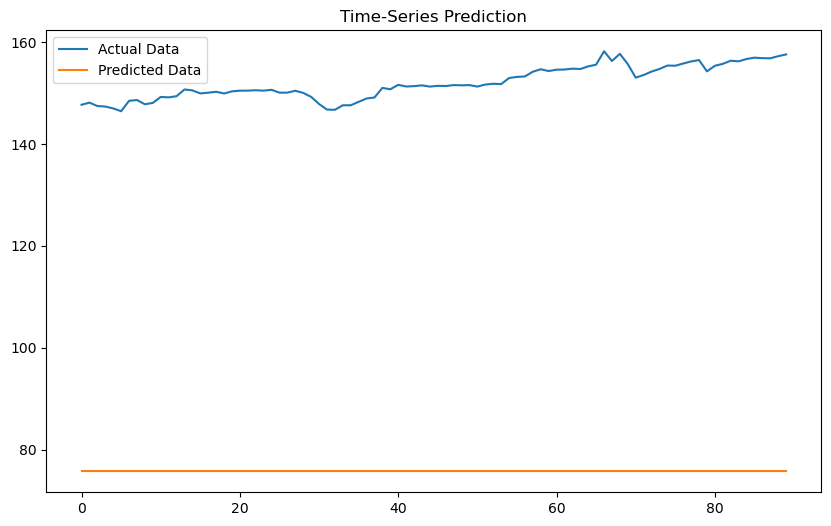

448


In [86]:
#df_X_ss = ss.transform(df1.drop(columns=['USDJPY'])) # old transformers
df_X_ss = ss.transform(df1)
df_y_mm = mm.transform(df1['USDJPY'].values.reshape(-1, 1)) # old transformers

# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, input_length, output_length, window_length)

# converting to tensors
df_X_ss = torch.Tensor(df_X_ss)
df_y_mm = torch.Tensor(df_y_mm)

# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], input_length, df_X_ss.shape[2]))

train_predict = lstm(df_X_ss) # forward pass

data_predict = train_predict.data.numpy() # numpy conversion

dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) # reverse transformation

dataY_plot = mm.inverse_transform(dataY_plot)

true, preds = [], []
for i in range(len(dataY_plot) - 90, len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(dataY_plot) - 90, len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(10,6)) #plotting
# plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set

plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.savefig("whole_plot.png", dpi=300)
plt.show() 
print(len(dataY_plot)-train_test_cutoff)